In [ ]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# import nltk
# from nltk.tokenize import word_tokenize
# from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split

# nltk.download('punkt')
# nltk.download('stopwords')
# stopwords_list = stopwords.words('english')

import torch
import torchtext
from torchtext import data
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#os.chdir("/content/drive/MyDrive/ECE1786/Project")
%cd /content/drive/MyDrive/Colab Notebooks/ECE1786/Project

/content/drive/MyDrive/Colab Notebooks/ECE1786/Project


In [ ]:
ls

baselines.ipynb  BERT_GRU.ipynb  data/                     GPT2.ipynb
BERT_base.ipynb  CNN.ipynb       data_preprocessing.ipynb


# Prepare the Data for Input
we will use TorchText with our edited Dataset to prepare the model input data

In [ ]:
train = pd.read_csv('data/train.tsv', sep="\t")[['tweet', 'class']]
val = pd.read_csv('data/validation.tsv', sep="\t")[['tweet', 'class']]
test = pd.read_csv('data/test.tsv', sep="\t")[['tweet', 'class']]

In [ ]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, vocab, split="train"):
        data_path = "data"
        df = pd.read_csv(os.path.join(data_path, f"{split}.tsv"), sep="\t")

        # X: torch.tensor (maxlen, batch_size), padded indices
        # Y: torch.tensor of len N
        X, Y = [], []
        V = len(vocab.vectors)
        for i, row in df.iterrows():
            L = row["tweet"].split()
            X.append(torch.tensor([vocab.stoi.get(w, V-1) for w in L]))  # Use the last word in the vocab as the "out-of-vocabulary" token
            Y.append(row["class"])
        self.X = X 
        self.Y = torch.tensor(Y)
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx] 
    
# my_collate_function prepares batches
# it also pads each batch with zeroes.

def my_collate_function(batch, device):
    # Handle the padding here
    # batch is approximately: [dataset[i] for i in range(0, batch_size)]
    # Since the dataset[i]'s contents is defined in the __getitem__() above, this collate function 
    # should be set correspondingly.
    # Also: collate_function just takes one argument. To pass in additional arguments (e.g., device), 
    # we need to wrap up an anonymous function (using lambda below)
    batch_x, batch_y = [], []
    max_len = 0
    for x,y in batch:
        batch_y.append(y)
        max_len = max(max_len, len(x))
    for x,y in batch:
        x_p = torch.concat(
            [x, torch.zeros(max_len - len(x))]
        )
        batch_x.append(x_p)
    return torch.stack(batch_x).t().int().to(device), torch.tensor(batch_y).to(device)

In [ ]:
batch_size_num = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
glove = torchtext.vocab.GloVe(name="6B",dim=100) # embedding size = 100
                                
train_dataset = TextDataset(glove, "train")
val_dataset = TextDataset(glove, "validation")
test_dataset = TextDataset(glove, "test")
    
train_dataloader = torch.utils.data.DataLoader(
  dataset=train_dataset, 
  batch_size=batch_size_num, 
  shuffle=False, 
  collate_fn=lambda batch: my_collate_function(batch, device))

validation_dataloader = torch.utils.data.DataLoader(
  dataset=val_dataset, 
  batch_size=batch_size_num, 
  shuffle=False, 
  collate_fn=lambda batch: my_collate_function(batch, device))

test_dataloader = torch.utils.data.DataLoader(
  dataset=test_dataset,
  batch_size=len(test_dataset),
  shuffle=False,
  collate_fn=lambda batch: my_collate_function(batch, device))



# Define the models & training

## SVM + BOW Baseline 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
tfidfvectorizer = TfidfVectorizer(analyzer='word', stop_words='english', max_features=5000)
X_train_tfidf = tfidfvectorizer.fit_transform(train['tweet'])
X_val_tfidf = tfidfvectorizer.transform(val['tweet'])
X_test_tfidf = tfidfvectorizer.transform(test['tweet'])

In [ ]:
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_validate, GridSearchCV

In [ ]:
linearsvc = LinearSVC() # implemented in terms of liblinear, so more flexibility and should scale better to large numbers of samples.
linearsvc.fit(X_train_tfidf, train['class'])
linearsvc_predictions = linearsvc.predict(X_test_tfidf)


In [ ]:
confusion_matrix(test['class'],linearsvc_predictions)
print(classification_report(test['class'],linearsvc_predictions))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90      2000
           1       0.91      0.86      0.88      2000
           2       0.94      0.97      0.95      2000

    accuracy                           0.91      6000
   macro avg       0.91      0.91      0.91      6000
weighted avg       0.91      0.91      0.91      6000



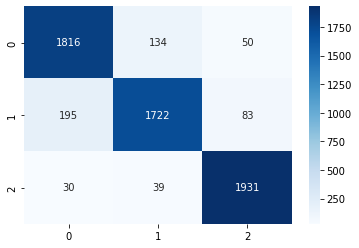

In [ ]:
sns.heatmap(confusion_matrix(test['class'],linearsvc_predictions), annot=True, fmt='.0f', cmap=plt.cm.Blues)
plt.show()

In [ ]:
lr = LogisticRegression(max_iter=200) # max_iter=100 by default, connot converge 
lr.fit(X_train_tfidf, train['class'])
lr_predictions = lr.predict(X_test_tfidf)


In [ ]:
print(classification_report(test['class'],lr_predictions))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      2000
           1       0.92      0.86      0.89      2000
           2       0.91      0.98      0.95      2000

    accuracy                           0.91      6000
   macro avg       0.91      0.91      0.91      6000
weighted avg       0.91      0.91      0.91      6000



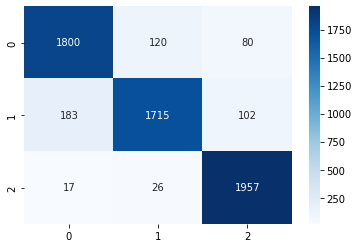

In [ ]:
sns.heatmap(confusion_matrix(test['class'],lr_predictions), annot=True, fmt='.0f', cmap=plt.cm.Blues)
plt.show()

## Neural Network + Words Embeddings Baseline

In [ ]:
class BaselineModel(torch.nn.Module):
    def __init__(self, embedding_size, vocab):
        super().__init__()
        self.embedding = torch.nn.Embedding.from_pretrained(vocab.vectors)  # embedding layer
        self.expanding = torch.nn.Linear(embedding_size, 3) # hidden layer
        
    def forward(self, x):
        e = self.embedding(x)
        output = self.expanding(torch.mean(e, 0))
        output = torch.softmax(output, 1)

        return output

In [ ]:
def train_model(glove, train_dataloader, validation_dataloader, learning_rate, epochs, batch_size):
    embedding_size = 100

    # Instantiate the model & set up the optimizer
    model = BaselineModel(embedding_size, glove)
    criterion = torch.nn.CrossEntropyLoss() # Cross Entropy [0.2 0.7 0.1] [0, 1, 0]
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_losses, val_losses, train_acc, val_acc = [], [], [], []

    for epoch in range(epochs):
        train_loss, val_loss, train_acc_count_epoch, val_acc_count_epoch = 0, 0, 0, 0

        for text, label in train_dataloader:
            # forward
            output = model(text) 
            loss = criterion(output.squeeze(), label)
            # output = torch.softmax(output, 1)
            output = torch.max(output, 1).indices
            train_acc_count_epoch += torch.sum(output == label).item()
            
            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        mean_train_loss = train_loss / len(train_dataloader)
        mean_train_acc = train_acc_count_epoch / (len(train_dataloader) * batch_size)

        with torch.no_grad():
            for text_val, label_val in validation_dataloader:
                output_val = model(text_val) 
                loss_val = criterion(output_val.squeeze(), label_val.squeeze())
                val_loss += loss_val.item()

                output_val = torch.softmax(output_val, 1)
                output_val = torch.max(output_val, 1).indices
                val_acc_count_epoch += torch.sum(output_val == label_val).item()

        mean_val_loss = val_loss / len(validation_dataloader)
        mean_val_acc = val_acc_count_epoch / (len(validation_dataloader) * batch_size)


        if epoch==0 or (epoch+1) % 10 == 0 or epoch == epochs-1:
            print(' Epoch {} \ttraining loss={:.7f} \tvalidation loss={:.7f}'.format(epoch+1,mean_train_loss,mean_val_loss))
            print('     \t\ttraining accuracy={:.2f}% \tvalidation accuracy={:.2f}%'.format(mean_train_acc*100, mean_val_acc*100))

        train_losses.append(mean_train_loss)
        val_losses.append(mean_val_loss)
        train_acc.append(mean_train_acc)
        val_acc.append(mean_val_acc)


    return model, train_losses, val_losses, train_acc, val_acc
  

In [ ]:
epochs = 150
learning_rate = 2e-3
torch.manual_seed(2) # fix seed

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print ("Using device:", device)


model, train_losses, val_losses, train_acc, val_acc = train_model(glove, train_dataloader, validation_dataloader, learning_rate, epochs, batch_size_num)


Using device: cpu
 Epoch 1 	training loss=1.0201226 	validation loss=0.9670240
     		training accuracy=55.56% 	validation accuracy=61.92%
 Epoch 10 	training loss=0.8223464 	validation loss=0.8207762
     		training accuracy=76.73% 	validation accuracy=76.52%
 Epoch 20 	training loss=0.7903013 	validation loss=0.7925353
     		training accuracy=78.38% 	validation accuracy=78.29%
 Epoch 30 	training loss=0.7766385 	validation loss=0.7805661
     		training accuracy=79.12% 	validation accuracy=78.71%
 Epoch 40 	training loss=0.7687963 	validation loss=0.7737884
     		training accuracy=79.59% 	validation accuracy=78.98%
 Epoch 50 	training loss=0.7635621 	validation loss=0.7693253
     		training accuracy=79.81% 	validation accuracy=79.06%
 Epoch 60 	training loss=0.7597945 	validation loss=0.7661713
     		training accuracy=80.03% 	validation accuracy=79.15%
 Epoch 70 	training loss=0.7569473 	validation loss=0.7638345
     		training accuracy=80.20% 	validation accuracy=79.23%
 Epoch 

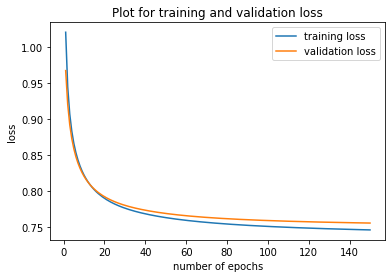

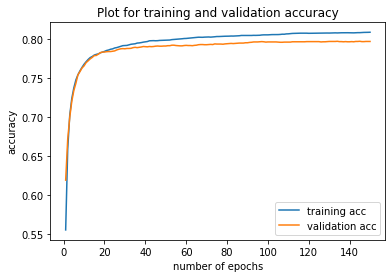

In [ ]:
fig = plt.figure()
plt.plot(range(1, epochs+1), train_losses, label ='training loss')
plt.plot(range(1, epochs+1), val_losses, label ='validation loss')
plt.title("Plot for training and validation loss")
plt.xlabel("number of epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

fig = plt.figure()
plt.plot(range(1, epochs+1), train_acc, label ='training acc')
plt.plot(range(1, epochs+1), val_acc, label ='validation acc')
plt.title("Plot for training and validation accuracy")
plt.xlabel("number of epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [ ]:
for text_test, label_test in test_dataloader:
    output_test = model(text_test) 
    output_test_softmax = torch.softmax(output_test, 1)
    label_pred = torch.max(output_test_softmax, 1).indices


In [ ]:
print(classification_report(label_test,label_pred))

              precision    recall  f1-score   support

           0       0.73      0.81      0.77      2000
           1       0.88      0.63      0.74      2000
           2       0.76      0.88      0.82      2000

    accuracy                           0.78      6000
   macro avg       0.79      0.78      0.77      6000
weighted avg       0.79      0.78      0.77      6000

              precision    recall  f1-score   support

           0       0.73      0.81      0.77      2000
           1       0.88      0.63      0.74      2000
           2       0.76      0.88      0.82      2000

    accuracy                           0.78      6000
   macro avg       0.79      0.78      0.77      6000
weighted avg       0.79      0.78      0.77      6000



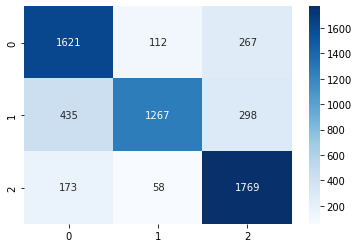

In [47]:
sns.heatmap(confusion_matrix(label_test,label_pred), annot=True, fmt='.0f', cmap=plt.cm.Blues)
plt.show()